In [59]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization
from pywsi.normalization import VahadaneNormalization


from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb
import numpy.linalg as LA
from skimage.filters import try_all_threshold

from sklearn.decomposition import NMF
from sklearn.decomposition import nmf
from sklearn.linear_model import Lasso

from skimage.io import imshow
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from skimage.filters import threshold_otsu

from pywsi.morphology.operations import open_close, close_open, imerode, imdilate, imopening, imclosing

from numpy import linalg as LA
from skimage.color import rgb2gray, gray2rgb
import spams
from scipy import ndimage as ndi

from skimage.feature import canny


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/saket/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imshow']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_100.tif'
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_004.tif'

tumor_wsi = WSIReader(tumor, 40)
normal_wsi = WSIReader(normal, 40)

In [3]:
x0 = int(59792/2)#30000
y0 = int(233184/2)

tumor_rgb = tumor_wsi.get_patch_by_level(x0, y0, level=0, patch_size=128)



In [4]:
tumor_rgb.shape

(128, 128, 3)

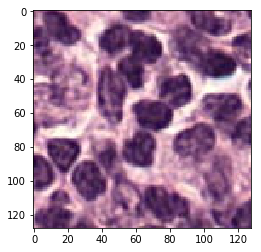

In [5]:
plt.imshow(tumor_rgb)


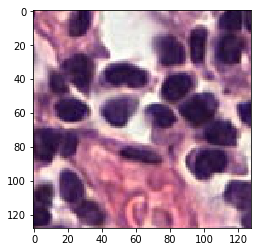

In [6]:
x0 = int(97792/2)
y0 = int(212992/1.5)

normal_rgb = normal_wsi.get_patch_by_level(x0, y0, level=0, patch_size=128)

plt.imshow(normal_rgb)

In [7]:
normal_wsi.level_dimensions[0]

(97792, 212992)

# Macenko normalization

In [8]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

In [9]:
vahadane_fit = VahadaneNormalization()
vahadane_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb_v = vahadane_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

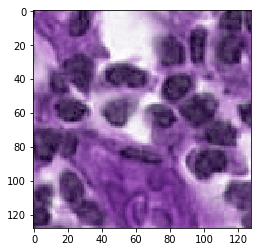

In [10]:
plt.imshow(normalized_rgb[0])

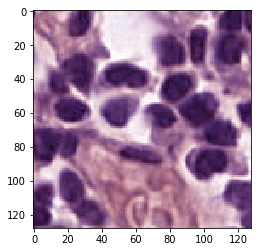

In [11]:
plt.imshow(normalized_rgb_v[0])

In [12]:
vahadane_fit.OD 

array([[0.87782445, 1.80359393, 1.3516088 ],
       [0.30482158, 0.72907919, 0.5645298 ],
       [0.09022509, 0.44139712, 0.33177739],
       ...,
       [1.32175584, 1.98591548, 1.15923691],
       [1.2927683 , 2.04475598, 1.11044675],
       [1.2105302 , 1.93034563, 1.04145387]])

In [13]:
macenko_fit.target_stain_matrix.shape

(2, 3)

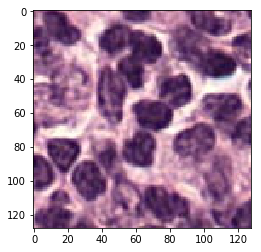

In [14]:
plt.imshow(tumor_rgb)


In [15]:
H_channel = macenko_fit.get_hematoxylin_channel(tumor_rgb)
E_channel = macenko_fit.get_eosin_channel(tumor_rgb)

H_channel_normal = macenko_fit.get_hematoxylin_channel(normal_rgb)
E_channel_normal = macenko_fit.get_eosin_channel(normal_rgb)

In [16]:
macenko_fit.target_concentrations#.shape

array([[0.99428194, 0.27104981],
       [0.88111432, 0.24959469],
       [0.69180451, 0.29895258],
       ...,
       [1.50869756, 0.5725141 ],
       [1.6691741 , 0.70785174],
       [1.74670167, 0.85464915]])

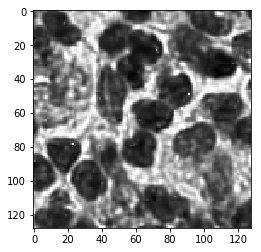

In [17]:
plt.imshow(rgb2gray(H_channel), cmap='gray')

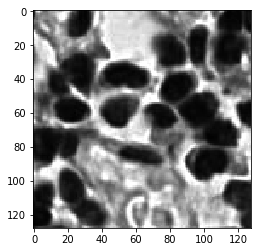

In [18]:
plt.imshow(rgb2gray(H_channel_normal), cmap='gray')

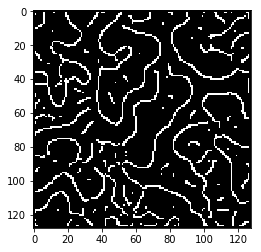

In [19]:
edges = canny(rgb2gray(H_channel), sigma=3,
              high_threshold=1)
plt.imshow(edges, cmap='gray')

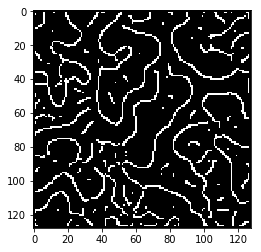

In [20]:
fill = ndi.binary_erosion(edges, structure=np.ones((1,1)))
plt.imshow(fill, cmap='gray')


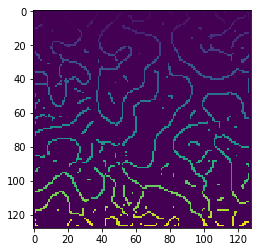

In [21]:
labeled, _ = ndi.label(fill)
plt.imshow(labeled)

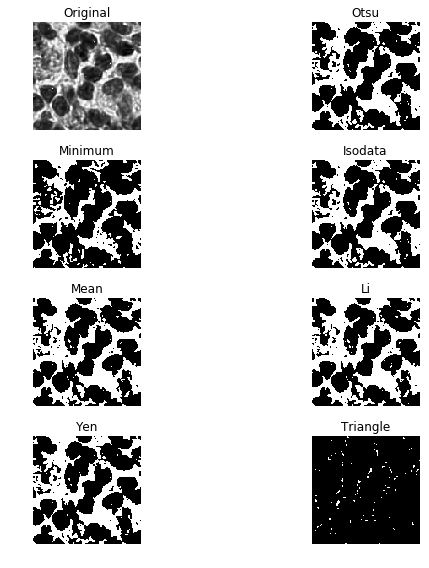

In [22]:
fig, ax = try_all_threshold(rgb2gray(H_channel), figsize=(10, 8), verbose=False)


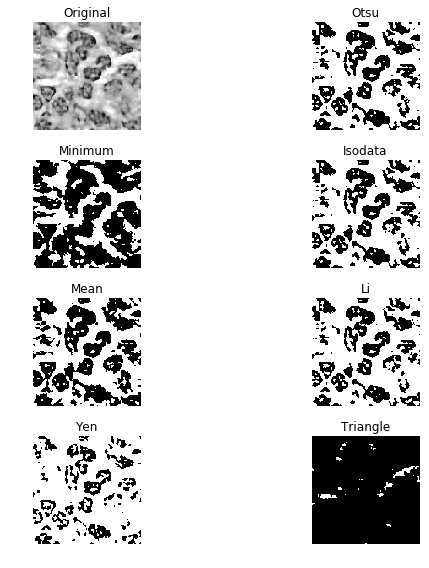

In [23]:
fig, ax = try_all_threshold(rgb2gray(E_channel), figsize=(10, 8), verbose=False)


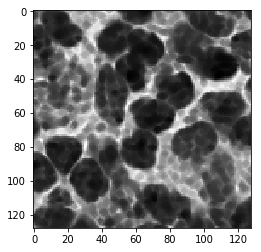

In [24]:
eroded = imerode(rgb2gray(H_channel), 1)
plt.imshow(eroded, cmap='gray')

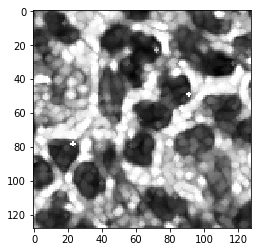

In [25]:
dilated = imdilate(rgb2gray(H_channel), 1)
plt.imshow(dilated, cmap='gray')

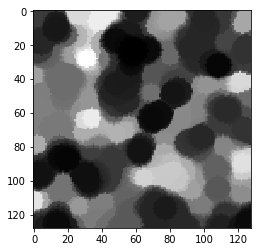

In [26]:
oc = open_close(rgb2gray(H_channel), 5, 7)
plt.imshow(oc, cmap='gray')

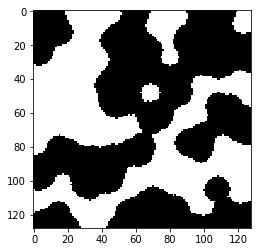

In [27]:

plt.imshow(oc > threshold_otsu(oc), cmap='gray')

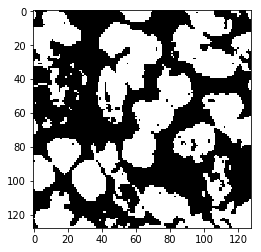

In [28]:
plt.imshow(rgb2gray(H_channel) < 100, cmap='gray')

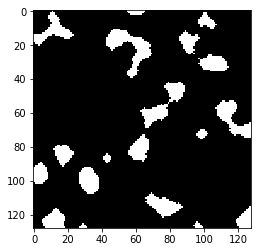

In [29]:
t = rgb2gray(H_channel) < 100
plt.imshow(imclosing(imopening(imerode(imerode(t, 2, True), 2, True), 2), 4), cmap='gray')

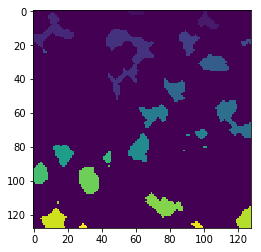

In [30]:
i = imerode(imerode(t, 2), 2)
labeled, x = ndi.label(i)
plt.imshow(labeled)

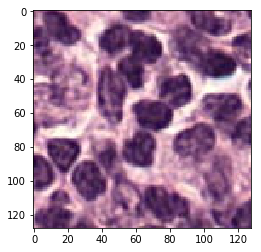

In [31]:
plt.imshow(tumor_rgb
          )

Text(0.5,1,'Normalized (Macenko)')

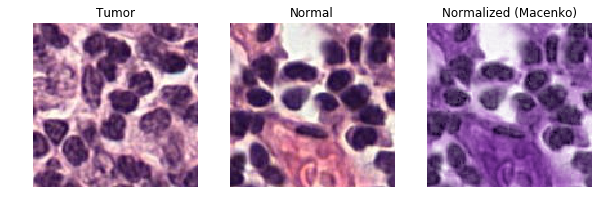

In [32]:
dif = plt.figure(figsize=(10, 10))
ax = plt.subplot(131)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(132)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')

ax = plt.subplot(133)
ax.set_axis_off()
ax.imshow(normalized_rgb[0])
ax.set_title('Normalized (Macenko)')




# Extreme example

In [33]:
i3 = read_as_rgb('../data/images/i3.png')

In [34]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(i3).astype(np.uint8))
H_channel = macenko_fit.get_hematoxylin_channel(i3)


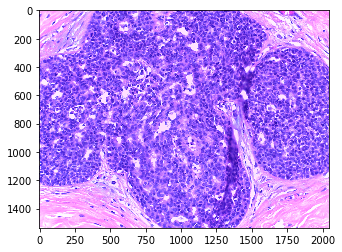

In [35]:
plt.imshow(i3)

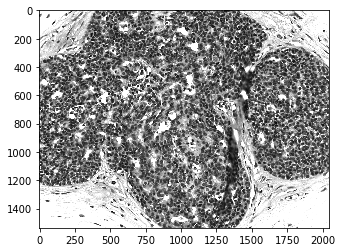

In [36]:
plt.imshow(H_channel, cmap='gray')

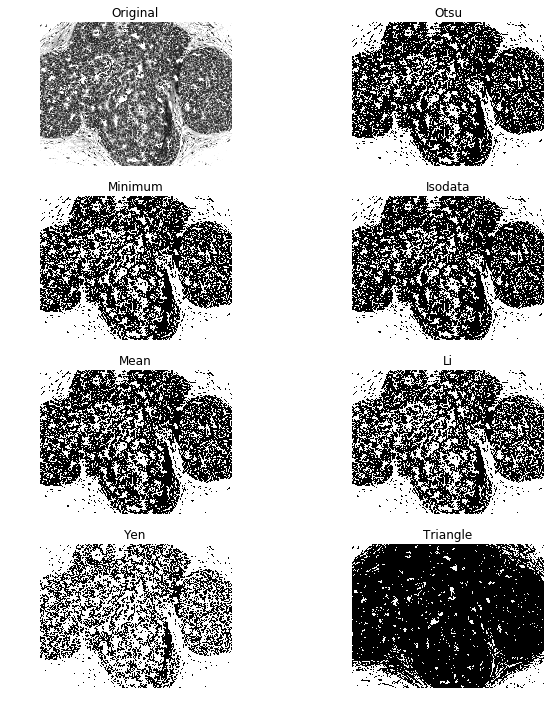

In [37]:
fig, ax = try_all_threshold(rgb2gray(H_channel), figsize=(10,10), verbose=False)

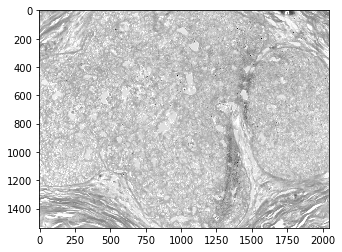

In [38]:
E_channel = macenko_fit.get_eosin_channel(i3)

plt.imshow(E_channel, cmap='gray')

In [40]:
v = read_as_rgb('../data/images/vahadane_ex.png')

In [41]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(v).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(v).astype(np.uint8))

In [42]:
vahadane_fit = VahadaneNormalization()
vahadane_fit.fit(np.asarray(v).astype(np.uint8))
normalized_rgb_v = vahadane_fit.transform(np.asarray(v).astype(np.uint8))

In [77]:
H_channel = macenko_fit.get_hematoxylin_channel(v)
E_channel = macenko_fit.getp[l_eosin_channel(v)

H_channel_v = vahadane_fit.get_hematoxylin_channel(v)
E_channel_v = vahadane_fit.get_eosin_channel(v)

/Z/personal-folders/interns/saket/github/pywsi/pywsi/normalization/macenko.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/saket/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/saket/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
  

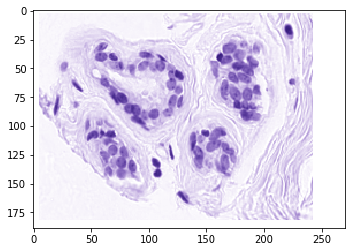

In [80]:
plt.imshow(H_channel/255)

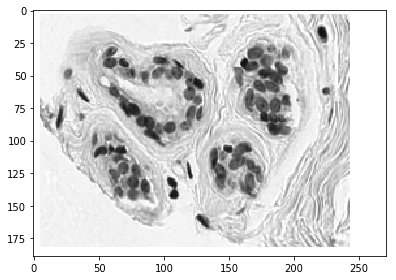

In [61]:
imshow(gray2rgb(H_channel/255))

In [57]:
E_channel.shape

(189, 271)

In [58]:
H_channel.shape

(189, 271)

array([237.68869626, 101.79623832, 172.71585898])

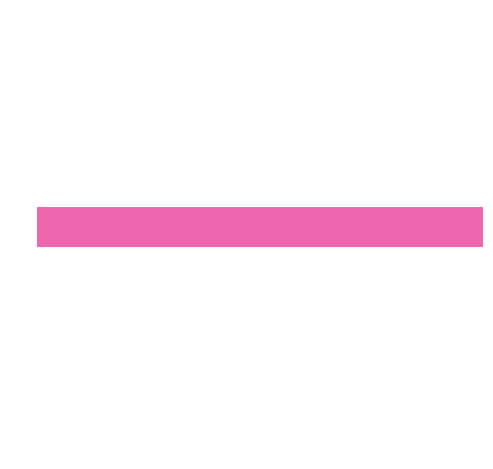

In [67]:
macenko_fit.get_eosin_stain()

array([145.37191281, 116.43554673, 195.84945819])

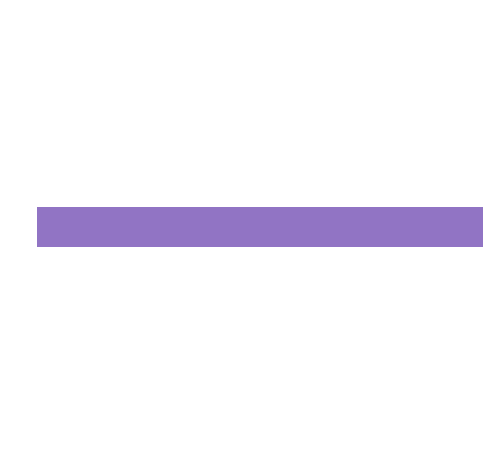

In [68]:
macenko_fit.get_hematoxylin_stain()